In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import os
from tqdm import tqdm


In [27]:
import torch
import random
import numpy as np

# Set random seed for Python random module
random_seed = 42
random.seed(random_seed)

# Set random seed for NumPy
np.random.seed(random_seed)

# Set random seed for PyTorch
torch.manual_seed(random_seed)

# Set random seed for CUDA if available
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)


### feature extraction model (ResNet50)

In [2]:

resnet = models.resnet50(pretrained=True).to('cuda')
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()


c:\Users\moham\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\moham\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\moham\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Res

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


### Autoencoder for learning latent distrbuitoin and for dimensionality reduction

In [28]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        #Encoder network
        
        self.fc0 = nn.Linear(2048, 1080)
        self.fc1 = nn.Linear(1080, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 2)

        #Decoder network

        self.fc7 = nn.Linear(2, 32)
        self.fc8 = nn.Linear(32, 64)
        self.fc9 = nn.Linear(64, 128)
        self.fc10 = nn.Linear(128, 256)
        self.fc11 = nn.Linear(256, 512)
        self.fc12 = nn.Linear(512, 1080)
        self.fc13 = nn.Linear(1080, 2048)
        

    def encode(self, x):
        h = torch.tanh(self.fc0(x))
        h = torch.tanh(self.fc1(h))
        h = torch.tanh(self.fc2(h))
        h = torch.tanh(self.fc3(h))
        h = torch.tanh(self.fc4(h))
        h = torch.tanh(self.fc5(h))

        return self.fc6(h)

    def decode(self, x):
        h = torch.tanh(self.fc7(x))
        h = torch.tanh(self.fc8(h))
        h = torch.tanh(self.fc9(h))
        h = torch.tanh(self.fc10(h))
        h = torch.tanh(self.fc11(h))
        h = torch.tanh(self.fc12(h))

        return self.fc13(h)
    
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

### loading and spliting data into training and validation

In [1]:
import os
import albumentations as A
import cv2
import torch
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, img_dir):
        """
        Args:
            dataframe (DataFrame): DataFrame with annotations.
            img_dir (string): Directory with all the images.
        """
        self.img_dir = img_dir
        self.imgs_path = [os.path.join(self.img_dir, img_name) for img_name in os.listdir(self.img_dir)]
        self.transform = A.Compose(
            [
                A.Resize(256, 256),
                A.ShiftScaleRotate(
                    shift_limit=0.1, scale_limit=0.15, rotate_limit=60, p=0.5
                ),
                A.HueSaturationValue(
                    hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5
                ),
                A.RandomBrightnessContrast(
                    brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5
                ),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                    max_pixel_value=255.0,
                    p=1.0,
                ),
                ToTensorV2(),
            ],
            p=1,
        )
        

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        img_name = self.imgs_path[idx]

        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)["image"]

        return image




In [5]:
from torch.utils.data import DataLoader, random_split


dataset = CustomDataset(r'D:\yousef\SBME 4\1\DL\project\train_thumbnails')
validation_split = 0.15
dataset_size = len(dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size = 1  # Adjust the batch size according to your needs
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


### extracting features using ResNet50

In [6]:
def extract_features(loader):
    features = []
    for batch in tqdm(loader):
        batch = batch.to('cuda')
        feature = resnet(batch)
        features.append(feature.cpu().detach().numpy())
    return features

In [7]:
train_features = extract_features(train_loader)
val_features = extract_features(val_loader)

train_features = np.array(train_features).reshape((np.shape(np.array(train_features))[0], -1))
val_features = np.array(val_features).reshape((np.shape(np.array(val_features))[0], -1))


100%|██████████| 76/76 [00:14<00:00,  5.34it/s]


### Autoencoder Training

In [29]:
train_features_loader = DataLoader(train_features, batch_size=32, shuffle=True)
val_features_loader = DataLoader(val_features, batch_size=32, shuffle=False)

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import wandb

# Initialize WandB
wandb.init(project="Anomlaies Detecton", config={"learning_rate": 0.001, "num_epochs": 100, 'batch_size': 32})

learning_rate = wandb.config.learning_rate
num_epochs = wandb.config.num_epochs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

autoEncoder = AE().to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoEncoder.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    # Training
    autoEncoder.train()
    total_loss = 0.0
    for i, data in enumerate(train_features_loader, 0):
        inputs = data
        inputs = inputs.to(device)

        optimizer.zero_grad()

        outputs = autoEncoder(inputs)
        loss = criterion(outputs, inputs)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_features_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {average_loss:.4f}")

    # Validation
    autoEncoder.eval()
    with torch.no_grad():
        total_val_loss = 0.0
        for i, val_data in tqdm(enumerate(val_features_loader, 0)):
            val_inputs = val_data
            val_inputs = val_inputs.to(device)

            val_outputs = autoEncoder(val_inputs)
            val_loss = criterion(val_outputs, val_inputs)

            total_val_loss += val_loss.item()

        average_val_loss = total_val_loss / len(val_features_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {average_val_loss:.4f}")

    # Log losses to WandB
    wandb.log({"training_loss": average_loss, "validation_loss": average_val_loss})

# Save the trained model
torch.save(autoEncoder.state_dict(), 'autoencoder_model.pth') 
print("Training finished.")


training_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▂▁▂▂▁▂▁▂▂▁▂▃▃▂▂▁▁▂▂▁▂▂▂▂▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁
training_loss,0.09621
validation_loss,0.08878


Epoch [1/100], Training Loss: 0.1941


3it [00:00, 429.85it/s]


Epoch [1/100], Validation Loss: 0.0961
Epoch [2/100], Training Loss: 0.1011


3it [00:00, 420.52it/s]

Epoch [2/100], Validation Loss: 0.0905


Epoch [3/100], Training Loss: 0.0972


3it [00:00, 426.63it/s]


Epoch [3/100], Validation Loss: 0.0906
Epoch [4/100], Training Loss: 0.0967


3it [00:00, 214.49it/s]


Epoch [4/100], Validation Loss: 0.0891
Epoch [5/100], Training Loss: 0.0963


3it [00:00, 428.79it/s]

Epoch [5/100], Validation Loss: 0.0890


Epoch [6/100], Training Loss: 0.0969


3it [00:00, 428.19it/s]

Epoch [6/100], Validation Loss: 0.0887


Epoch [7/100], Training Loss: 0.0963


3it [00:00, 428.68it/s]

Epoch [7/100], Validation Loss: 0.0896


Epoch [8/100], Training Loss: 0.0962


3it [00:00, 456.96it/s]

Epoch [8/100], Validation Loss: 0.0886


Epoch [9/100], Training Loss: 0.0968


3it [00:00, 426.47it/s]

Epoch [9/100], Validation Loss: 0.0893


Epoch [10/100], Training Loss: 0.0971


3it [00:00, 426.47it/s]

Epoch [10/100], Validation Loss: 0.0889


Epoch [11/100], Training Loss: 0.0966


3it [00:00, 426.42it/s]

Epoch [11/100], Validation Loss: 0.0894


Epoch [12/100], Training Loss: 0.0967


3it [00:00, 427.12it/s]

Epoch [12/100], Validation Loss: 0.0895


Epoch [13/100], Training Loss: 0.0963


3it [00:00, 377.04it/s]

Epoch [13/100], Validation Loss: 0.0888


Epoch [14/100], Training Loss: 0.0968


3it [00:00, 497.17it/s]

Epoch [14/100], Validation Loss: 0.0891


Epoch [15/100], Training Loss: 0.0967


3it [00:00, 373.25it/s]

Epoch [15/100], Validation Loss: 0.0891


Epoch [16/100], Training Loss: 0.0970


3it [00:00, 496.68it/s]

Epoch [16/100], Validation Loss: 0.0896


Epoch [17/100], Training Loss: 0.0972


3it [00:00, 398.45it/s]

Epoch [17/100], Validation Loss: 0.0890


Epoch [18/100], Training Loss: 0.0964


3it [00:00, 298.78it/s]

Epoch [18/100], Validation Loss: 0.0888


Epoch [19/100], Training Loss: 0.0962


3it [00:00, 428.95it/s]

Epoch [19/100], Validation Loss: 0.0889


Epoch [20/100], Training Loss: 0.0963


3it [00:00, 335.12it/s]

Epoch [20/100], Validation Loss: 0.0896


Epoch [21/100], Training Loss: 0.0966


3it [00:00, 374.35it/s]

Epoch [21/100], Validation Loss: 0.0893


Epoch [22/100], Training Loss: 0.0962


3it [00:00, 374.11it/s]

Epoch [22/100], Validation Loss: 0.0891


Epoch [23/100], Training Loss: 0.0957


3it [00:00, 300.01it/s]

Epoch [23/100], Validation Loss: 0.0887


Epoch [24/100], Training Loss: 0.0964


3it [00:00, 428.63it/s]

Epoch [24/100], Validation Loss: 0.0897


Epoch [25/100], Training Loss: 0.0964


3it [00:00, 499.46it/s]

Epoch [25/100], Validation Loss: 0.0889


Epoch [26/100], Training Loss: 0.0964


3it [00:00, 200.17it/s]

Epoch [26/100], Validation Loss: 0.0895


Epoch [27/100], Training Loss: 0.0958


3it [00:00, 429.98it/s]

Epoch [27/100], Validation Loss: 0.0893


Epoch [28/100], Training Loss: 0.0957


3it [00:00, 426.39it/s]

Epoch [28/100], Validation Loss: 0.0882


Epoch [29/100], Training Loss: 0.0908


3it [00:00, 500.12it/s]

Epoch [29/100], Validation Loss: 0.0811


Epoch [30/100], Training Loss: 0.0878


3it [00:00, 501.23it/s]

Epoch [30/100], Validation Loss: 0.0866


Epoch [31/100], Training Loss: 0.0863


3it [00:00, 375.13it/s]

Epoch [31/100], Validation Loss: 0.0803


Epoch [32/100], Training Loss: 0.0856


3it [00:00, 430.60it/s]

Epoch [32/100], Validation Loss: 0.0790


Epoch [33/100], Training Loss: 0.0838


3it [00:00, 428.62it/s]

Epoch [33/100], Validation Loss: 0.0793


Epoch [34/100], Training Loss: 0.0827


3it [00:00, 428.63it/s]

Epoch [34/100], Validation Loss: 0.0783


Epoch [35/100], Training Loss: 0.0819


3it [00:00, 375.15it/s]

Epoch [35/100], Validation Loss: 0.0776


Epoch [36/100], Training Loss: 0.0818


3it [00:00, 375.21it/s]

Epoch [36/100], Validation Loss: 0.0772


Epoch [37/100], Training Loss: 0.0814


3it [00:00, 468.08it/s]

Epoch [37/100], Validation Loss: 0.0769


Epoch [38/100], Training Loss: 0.0808


3it [00:00, 428.12it/s]

Epoch [38/100], Validation Loss: 0.0766


Epoch [39/100], Training Loss: 0.0817


3it [00:00, 500.65it/s]

Epoch [39/100], Validation Loss: 0.0790


Epoch [40/100], Training Loss: 0.0823


3it [00:00, 374.81it/s]

Epoch [40/100], Validation Loss: 0.0780


Epoch [41/100], Training Loss: 0.0812


3it [00:00, 428.66it/s]

Epoch [41/100], Validation Loss: 0.0771


Epoch [42/100], Training Loss: 0.0797


3it [00:00, 375.03it/s]

Epoch [42/100], Validation Loss: 0.0757


Epoch [43/100], Training Loss: 0.0796


3it [00:00, 429.28it/s]

Epoch [43/100], Validation Loss: 0.0789


Epoch [44/100], Training Loss: 0.0802


3it [00:00, 375.07it/s]

Epoch [44/100], Validation Loss: 0.0759


Epoch [45/100], Training Loss: 0.0790


3it [00:00, 374.27it/s]

Epoch [45/100], Validation Loss: 0.0748


Epoch [46/100], Training Loss: 0.0789


3it [00:00, 428.19it/s]

Epoch [46/100], Validation Loss: 0.0768


Epoch [47/100], Training Loss: 0.0798


3it [00:00, 333.02it/s]

Epoch [47/100], Validation Loss: 0.0771


Epoch [48/100], Training Loss: 0.0793


3it [00:00, 430.80it/s]

Epoch [48/100], Validation Loss: 0.0764


Epoch [49/100], Training Loss: 0.0794


3it [00:00, 426.76it/s]

Epoch [49/100], Validation Loss: 0.0753


Epoch [50/100], Training Loss: 0.0830


3it [00:00, 333.71it/s]

Epoch [50/100], Validation Loss: 0.0802


Epoch [51/100], Training Loss: 0.0811


3it [00:00, 374.61it/s]

Epoch [51/100], Validation Loss: 0.0761


Epoch [52/100], Training Loss: 0.0791


3it [00:00, 428.06it/s]

Epoch [52/100], Validation Loss: 0.0755


Epoch [53/100], Training Loss: 0.0791


3it [00:00, 376.46it/s]

Epoch [53/100], Validation Loss: 0.0770


Epoch [54/100], Training Loss: 0.0798


3it [00:00, 428.08it/s]

Epoch [54/100], Validation Loss: 0.0779


Epoch [55/100], Training Loss: 0.0798


3it [00:00, 497.21it/s]

Epoch [55/100], Validation Loss: 0.0769


Epoch [56/100], Training Loss: 0.0784


3it [00:00, 205.83it/s]

Epoch [56/100], Validation Loss: 0.0768


Epoch [57/100], Training Loss: 0.0790


3it [00:00, 333.04it/s]

Epoch [57/100], Validation Loss: 0.0755


Epoch [58/100], Training Loss: 0.0784


3it [00:00, 458.93it/s]

Epoch [58/100], Validation Loss: 0.0769


Epoch [59/100], Training Loss: 0.0785


3it [00:00, 374.40it/s]

Epoch [59/100], Validation Loss: 0.0739


Epoch [60/100], Training Loss: 0.0773


3it [00:00, 187.37it/s]

Epoch [60/100], Validation Loss: 0.0732


Epoch [61/100], Training Loss: 0.0770


3it [00:00, 375.06it/s]

Epoch [61/100], Validation Loss: 0.0742


Epoch [62/100], Training Loss: 0.0766


3it [00:00, 428.65it/s]

Epoch [62/100], Validation Loss: 0.0730


Epoch [63/100], Training Loss: 0.0766


3it [00:00, 428.62it/s]

Epoch [63/100], Validation Loss: 0.0737


Epoch [64/100], Training Loss: 0.0774


3it [00:00, 427.09it/s]

Epoch [64/100], Validation Loss: 0.0738


Epoch [65/100], Training Loss: 0.0769


3it [00:00, 500.02it/s]

Epoch [65/100], Validation Loss: 0.0736


Epoch [66/100], Training Loss: 0.0765


3it [00:00, 272.25it/s]

Epoch [66/100], Validation Loss: 0.0744


Epoch [67/100], Training Loss: 0.0773


3it [00:00, 375.14it/s]

Epoch [67/100], Validation Loss: 0.0734


Epoch [68/100], Training Loss: 0.0762


3it [00:00, 431.38it/s]

Epoch [68/100], Validation Loss: 0.0725


Epoch [69/100], Training Loss: 0.0762


3it [00:00, 428.57it/s]

Epoch [69/100], Validation Loss: 0.0712


Epoch [70/100], Training Loss: 0.0755


3it [00:00, 428.76it/s]

Epoch [70/100], Validation Loss: 0.0711


Epoch [71/100], Training Loss: 0.0763


3it [00:00, 374.98it/s]

Epoch [71/100], Validation Loss: 0.0750


Epoch [72/100], Training Loss: 0.0764


3it [00:00, 229.90it/s]

Epoch [72/100], Validation Loss: 0.0713


Epoch [73/100], Training Loss: 0.0755


3it [00:00, 429.22it/s]

Epoch [73/100], Validation Loss: 0.0755


Epoch [74/100], Training Loss: 0.0775


3it [00:00, 375.21it/s]

Epoch [74/100], Validation Loss: 0.0726


Epoch [75/100], Training Loss: 0.0758


3it [00:00, 429.03it/s]

Epoch [75/100], Validation Loss: 0.0731


Epoch [76/100], Training Loss: 0.0778


3it [00:00, 428.66it/s]

Epoch [76/100], Validation Loss: 0.0744


Epoch [77/100], Training Loss: 0.0784


3it [00:00, 375.32it/s]

Epoch [77/100], Validation Loss: 0.0738


Epoch [78/100], Training Loss: 0.0756


3it [00:00, 350.78it/s]

Epoch [78/100], Validation Loss: 0.0735


Epoch [79/100], Training Loss: 0.0773


3it [00:00, 428.46it/s]

Epoch [79/100], Validation Loss: 0.0731


Epoch [80/100], Training Loss: 0.0771


3it [00:00, 199.38it/s]

Epoch [80/100], Validation Loss: 0.0717


Epoch [81/100], Training Loss: 0.0749


3it [00:00, 428.59it/s]

Epoch [81/100], Validation Loss: 0.0728


Epoch [82/100], Training Loss: 0.0791


3it [00:00, 333.19it/s]

Epoch [82/100], Validation Loss: 0.0751


Epoch [83/100], Training Loss: 0.0769


3it [00:00, 464.85it/s]

Epoch [83/100], Validation Loss: 0.0726


Epoch [84/100], Training Loss: 0.0744


3it [00:00, 374.99it/s]

Epoch [84/100], Validation Loss: 0.0729


Epoch [85/100], Training Loss: 0.0740


3it [00:00, 250.02it/s]

Epoch [85/100], Validation Loss: 0.0714


Epoch [86/100], Training Loss: 0.0765


3it [00:00, 428.69it/s]

Epoch [86/100], Validation Loss: 0.0723


Epoch [87/100], Training Loss: 0.0751


3it [00:00, 373.37it/s]

Epoch [87/100], Validation Loss: 0.0722


Epoch [88/100], Training Loss: 0.0742


3it [00:00, 457.05it/s]

Epoch [88/100], Validation Loss: 0.0721


Epoch [89/100], Training Loss: 0.0743


3it [00:00, 496.96it/s]

Epoch [89/100], Validation Loss: 0.0735


Epoch [90/100], Training Loss: 0.0751


3it [00:00, 249.87it/s]

Epoch [90/100], Validation Loss: 0.0717


Epoch [91/100], Training Loss: 0.0743


3it [00:00, 214.46it/s]

Epoch [91/100], Validation Loss: 0.0751


Epoch [92/100], Training Loss: 0.0747


3it [00:00, 426.28it/s]

Epoch [92/100], Validation Loss: 0.0712


Epoch [93/100], Training Loss: 0.0781


3it [00:00, 462.18it/s]

Epoch [93/100], Validation Loss: 0.0742


Epoch [94/100], Training Loss: 0.0754


3it [00:00, 430.49it/s]

Epoch [94/100], Validation Loss: 0.0724


Epoch [95/100], Training Loss: 0.0734


3it [00:00, 284.43it/s]

Epoch [95/100], Validation Loss: 0.0717


Epoch [96/100], Training Loss: 0.0746


3it [00:00, 499.28it/s]

Epoch [96/100], Validation Loss: 0.0753


Epoch [97/100], Training Loss: 0.0748


3it [00:00, 375.41it/s]

Epoch [97/100], Validation Loss: 0.0705


Epoch [98/100], Training Loss: 0.0736


3it [00:00, 500.97it/s]

Epoch [98/100], Validation Loss: 0.0697


Epoch [99/100], Training Loss: 0.0729


3it [00:00, 272.67it/s]

Epoch [99/100], Validation Loss: 0.0713


Epoch [100/100], Training Loss: 0.0729


3it [00:00, 428.03it/s]

Epoch [100/100], Validation Loss: 0.0744
Training finished.


### using trained Encoder for dimensionality reduction and extracting feature from the learnt distribution

In [43]:
def extract_ecnoder_features(features):
    features = autoEncoder.encode(torch.tensor(features).to('cuda'))
    return features.cpu().detach().numpy()  # Convert to NumPy array for SVM

In [44]:
low_dim_train_features = extract_ecnoder_features(train_features)
low_dim_val_features = extract_ecnoder_features(val_features)

In [46]:
all_features = np.concatenate((low_dim_train_features, low_dim_val_features), axis=0)

### latent space distribution

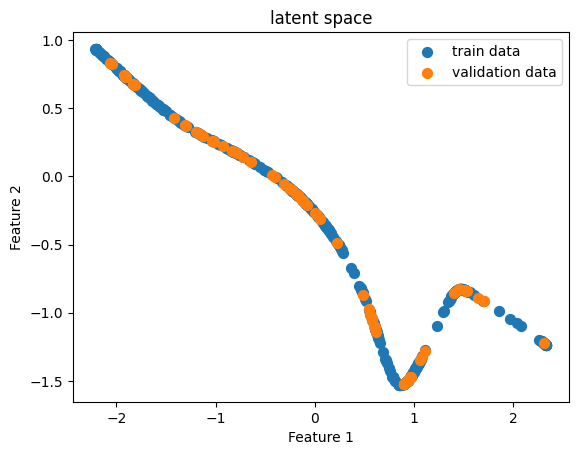

In [52]:

import matplotlib.pyplot as plt
import numpy as np

plt.scatter(low_dim_train_features[:, 0], low_dim_train_features[:, 1], s=50, label= 'train data')
plt.scatter(low_dim_val_features[:, 0], low_dim_val_features[:, 1], s=50, label= 'validation data')
plt.title("latent space")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

### one-class SVM model for outlier detection

In [75]:
from sklearn import svm 

svm = svm.OneClassSVM(kernel='sigmoid', nu=0.1)
svm.fit(low_dim_train_features)


44

In [93]:
svm_pred = svm.predict(low_dim_val_features)
outliers_indices = np.where(svm_pred == -1)[0]
len(outliers_indices)

4

In [94]:
fasle_positives_acc = len(outliers_indices) / len(low_dim_val_features)
print(f"false positive rate on testing data: {fasle_positives_acc:.2f}")

false positive rate on testing data: 0.05


In [95]:
svm_pred = svm.predict(low_dim_train_features)
outliers_indices = np.where(svm_pred == -1)[0]
len(outliers_indices)

44

In [96]:
fasle_positives_acc = len(outliers_indices) / len(low_dim_train_features)
print(f"false positive rate on training data: {fasle_positives_acc:.2f}")

false positive rate on training data: 0.10
